# Analysis of PRDE - determine optimal parameters

PRDE - PRZI with Differential Evolution
- *k*: the number of candidate solutions available to choose
- *F*: the differential weight

The goal of this research is to analyse the effects of *k* and *F* on the behaviour of PRDE, and try and produce a (*k*, *F*) pair that outperforms the available agent on GitHub.

### Replicating published results

To gain a better understanding of PRDE and the task at hand, the experiment from **Metapopulation Differential Co-Evolution of
Trading Strategies in a Model Financial Market** will be recreated. The experiment parameters taken from the paper are:

- 30 PRDE sellers
- 30 PRDE buyers
- 300 days of continuous trading time
- 20 total trials
- *k* = 4 (to compare with PRSH)
- *F* = 0.8 (taken from GitHub)

Since time for this research is limited, executing the same number of trials for the same amount of time is infeasible, however, and so only a handful of trials will be run for ~50 trading days. For these reasons, static supply and demand schedules will also be used.

In [ ]:
# import dependencies
from BSE import market_session
from BSE_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import csv
import time

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)

In [ ]:
# configure trader specification
sellers_spec = [('PRDE', 30, {'k': 4, 's_min': -1.0, 's_max': +1.0})]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'jittered'

plot_sup_dem(10, [sup_range], 10, [dem_range], stepmode)

# configure order schedules
no_days = 5
start_time = 0
end_time = int(no_days * 24*60*60)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

In [ ]:
trial_id = 'output/initial-trials/trial_1'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# run market session
# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

In [ ]:
# plot the trades that executed during the market session
# plot_trades(trial_id)

In [ ]:
def unpack_strats(filename):
    data = []
    best_data = []

    # unpack output file into csv
    with open(filename) as strats:
        reader = csv.reader(strats)

        # each row corresponds with a single eval epoch (7200s)
        for row in reader:
            time = row[1]

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-12].replace(" ", ""),
                        'actvstrat': float(row[-8]),
                        'actvpps': float(row[-10])
                    })

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-6].replace(" ", ""),
                        'actvstrat': float(row[-2]),
                        'actvpps': float(row[-4])
                    })

            # truncate list
            row = row[2:-13]

            # each row contains active pps and strat for each trader
            for i, item in enumerate(row):
                if i % 7 != 0:
                    continue
                else:
                    data.append({
                        't': int(time),
                        'id': row[i+1].replace(" ", ""),
                        'trader': row[i+2].replace(" ", ""),
                        'actvstrat': float(row[i+4]),
                        'actvpps': float(row[i+6])
                    })

        # convert list of dicts into df
        df = pd.DataFrame.from_records(data)
        best_df = pd.DataFrame.from_records(best_data)
    return df, best_df
   
# PRDE strats output file
filename = 'output/initial-trials/trial_1_strats.csv'

prde_df, prde_best_df = unpack_strats(filename)

# convert seconds to days
prde_df['t'] = prde_df['t'] / (24*60*60)
prde_best_df['t'] = prde_best_df['t'] / (24*60*60)

print(prde_df.tail())

In [ ]:
print(prde_best_df.tail())

In [ ]:
# plot pps for the best traders
prde_best_df.groupby('t').sum()['actvpps'].plot()

In [ ]:
# plot average pps for PRDE
prde_df.groupby('t').sum()['actvpps'].plot()

### Running the same experiment with PRSH for comparison

In [ ]:
# configure trader specification
sellers_spec = [('PRSH', 30, {'F': 0.8, 'k': 4, 's_min': -1.0, 's_max': +1.0})]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

trial_id = 'output/initial-trials/trial_2'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# run market session
# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

# plot the trades that executed during the market session
# plot_trades(trial_id)

In [ ]:
# PRSH strats output file
filename = 'output/initial-trials/trial_2_strats.csv'

prsh_df, prsh_best_df = unpack_strats(filename)

# convert seconds to days
prsh_df['t'] = prsh_df['t'] / (24*60*60)
prsh_best_df['t'] = prsh_best_df['t'] / (24*60*60)

In [ ]:
# plot pps for the best traders
prsh_best_df.groupby('t').sum()['actvpps'].plot()

In [ ]:
# plot average pps for PRDE
prsh_df.groupby('t').sum()['actvpps'].plot()

## Construct market conditions

The market conditions used to test the traders are important in the validity of the experiments run. The main types of markets that occur are:

- trending (bull or bear)
- trendless (static)
- ranging (moving up and down)

Risk based tests to test the robustness of the trading algorithms:

- Increase supply into the market
- Restrict supply into the market
- Increase demand into the market
- Restrict demand into the market

Supply and demand schedules need to be constructed to properly model these market conditions and scenarios.

### Trending market (bull / bear)

- Can be modelled using a linearly increasing offset function with the supply and demand range.
- In a bull market the average YTD returns are about 10-15%.
- A 10-15% increase in the limits over the trading session can be used to model this.

Assuming the trading session lasts for 5 days:

In [ ]:
def trending_offset(t):
    return int(0.0003 * t)

# plot offset func over a 5 min period
plot_offset_fn(trending_offset, 10*24*60*60)

The graph shows the increase of limit price over time. Below is a simulation run with ZIP traders to check that they display the linear trend over time.

In [ ]:
sellers_spec = [('ZIP', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

sup_range = (100, 200, trending_offset)
dem_range = (100, 200, trending_offset)

start_time = 0
end_time = 5*24*60 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'output/initial-trials/trial_3'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades(trial_id)

NB: For the actual simulation the gradient of the slope will be much steeper to allow for a more realistic simulation and so as to have the overall price range within reasonable bounds for comparison. The BSE max price limit is 500 and if the limit orders went above that value the absolute profit should not be used and instead a comparison of the percentage profits between traders would be more justified.

### Ranging market

A ranging market can be initially modelled through a sinusoidal offset function.

In [ ]:
def ranging_offset(t):
    c = math.pi * 5000
    wavelength = 100 / c
    bias = 100
    amplitude = 100
    offset = bias + amplitude * math.sin(wavelength * t)
    return int(round(offset, 0))

# plot offset func over a 15 min period
plot_offset_fn(ranging_offset, 15*60)

In [ ]:
params = {'k': 4, 'F': 0.8, 's_min': -1.0, 's_max': +1.0}
sellers_spec = [('ZIP', 10, params)]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

sup_range = (100, 200, ranging_offset)
dem_range = (100, 200, ranging_offset)

start_time = 0
end_time = 60 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'output/initial-trials/trial_4'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = False
verbose = False

# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades(trial_id)

NB: For the actual simulation the wavelength of the sinusoid would be much larger so as to simulate a real ranging market more accurately. A real financial market may take several months to move up and down.

## Varying k in PRDE

The 'k' parameter controls the number of available strategies to cycle through. Having more strategies is favourable since it increases the chance that a profitable strategy is hit, allowing the trader to converge on the optimum strategy more quickly. However, this is only true up to a point, and this analysis will be focussed on where that lies (for a constant F = 0.8).

To quantitatively determine the most profitable value for 'k', the total sum of all traders in the simulation will be found and compared. Where this total sum converges to will determine how highly a trial ranks in comparison with the others.

In [ ]:
from BSE import market_session

In [161]:
def PRDE_config(k, F=0.8):
    params = {'k': k, 'F': F, 's_min': -1.0, 's_max': +1.0, 'wait_time': 60*60*2}
    sellers_spec = [('PRDE', 30, params)]
    buyers_spec = sellers_spec
    return {'sellers': sellers_spec, 'buyers': buyers_spec}

def trending_offset(t):
    return int(0.0003 * t)

# confiure the supply and demand (and plot it)
sup_range = (100, 200, trending_offset)
dem_range = (100, 200, trending_offset)

stepmode = 'jittered'

# plot_sup_dem(10, [sup_range], 10, [dem_range], stepmode)

# configure order schedules
no_days = 10
# no_days = 1/24/60
start_time = 0
end_time = int(no_days * 24*60*60)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}



In [9]:
output_file = 'output/varying-k1/'

def vary_k(start=4, end=24, step=2):
    tstart = time.time()
    i = 1
    
    for k in range(start, end, step):
        # configure trader spec
        traders_spec = PRDE_config(k)
        
        # calculate overall progress
        progress = (k - start) / (end - start)
        
        # generate trial id and output file
        trial_id = output_file + 'trial_' + str(int(i)).zfill(2)
        tdump = open(trial_id + '_avg_balance.csv','w')
        
        # run market session
        market_session(trial_id, 
                       start_time, 
                       end_time, 
                       traders_spec, 
                       order_sched, 
                       tdump, 
                       dump_all=True, 
                       verbose=False, 
                       outer_progress=progress)
        
        # close output file
        tdump.close()
        
        # increase counter
        i += 1
        
    # calculate computation time
    tend = time.time()
    t = tend - tstart
    print('\nTime taken:', time.strftime("%H:%M:%S", time.gmtime(t)))

# vary_k(4, 5, 1)

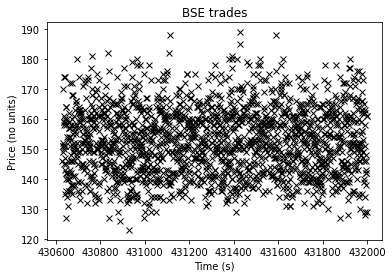

In [10]:
filename = output_file + 'trial_01'
plot_trades(filename)

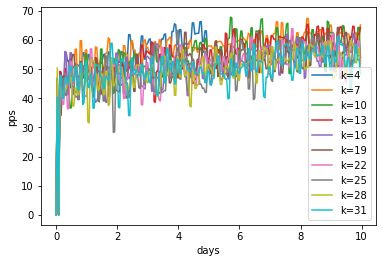

In [11]:
# legend values for k
k_leg = [i for i in range(4, 32, 3)]

plt.figure()

for i in range(1, 11):
    trial_id = output_file + 'trial_' + str(int(i)).zfill(2)

    # PRDE strats output file
    filename = trial_id + '_strats.csv'

    df, best_df = unpack_strats(filename)

    # convert seconds to days
    df['t'] = df['t'] / (24*60*60)
    
    # rename col for legend
    df.rename(columns = {'actvpps': f'k={k_leg[i-1]}'}, inplace=True)
    
    # plot average pps for PRDE
    df.groupby('t').sum()[f'k={k_leg[i-1]}']\
    .plot(xlabel='days', ylabel='pps', legend=True)

# plt.ylim([30, 70])
plt.show()

Although it appears as if all k-values converge to very similar points, k=10 and k=13 seem to be consistently above the rest of the strategies. Statistical tests would have to be run to confirm this hypothesis however.
- Try apply a rolling average to smooth out noise

However, the function that is being optimised (`market_session()`) is expensive to run and is known as a 'black box' - no closed form is known nor its gradients. This is ideal for Bayesian optimisation.

Bayesian optimisation converges on the optimal parameters by updating the expected utility based on previous results. This means that its search is continuously refined unlike the previous approach (Grid Search).

Note: the trending bull market did not appear to have much effect on the results of the traders. For BO a static market will be used, and in future testing market shocks will be utilised to determine the effectiveness of the traders.

## Bayesian Optimisation

There are several Python packages available for Bayesian Optimisation, however, `bayes_opt` one was chosen due to its extensive documentation, its apparent ease of implementation, and many examples available online for variations of the problem.

Note: there was a dependenct issue with v1.4.2 so v1.4.1 is used in this analysis. 

In [1]:
# %pip install bayesian-optimization==1.4.1

In [1]:
# import dependencies
from BSE import market_session
from BSE_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

# removes pandas warnings
import warnings
warnings.filterwarnings("ignore")

# save optimiser object
import pickle

In [2]:
# configure traders
def traders_config(k, f, no_traders=30):
    params = {'k': k, 'F': f, 's_min': -1.0, 's_max': +1.0, 'wait_time': 60*60*2}
    sellers_spec = [('PRDE', no_traders, params)]
    buyers_spec = sellers_spec
    return {'sellers': sellers_spec, 'buyers': buyers_spec}

# unpack data from strats file
def unpack_strats(filename):
    data = []
    best_data = []

    # unpack output file into a list of dicts
    with open(filename) as strats:
        reader = csv.reader(strats)

        # each row corresponds with a single eval epoch (7200s)
        for row in reader:
            time = row[1]

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-12].replace(" ", ""),
                        'actvstrat': float(row[-8]),
                        'actvpps': float(row[-10])
                    })

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-6].replace(" ", ""),
                        'actvstrat': float(row[-2]),
                        'actvpps': float(row[-4])
                    })

            # truncate list
            row = row[2:-13]

            # each row contains active pps and strat for each trader
            for i, item in enumerate(row):
                if i % 7 != 0:
                    continue
                else:
                    data.append({
                        't': int(time),
                        'id': row[i+1].replace(" ", ""),
                        'trader': row[i+2].replace(" ", ""),
                        'actvstrat': float(row[i+4]),
                        'actvpps': float(row[i+6])
                    })

        # convert list of dicts into df
        df = pd.DataFrame.from_records(data)
        best_df = pd.DataFrame.from_records(best_data)
    return df, best_df

# unpack data from avg balance file
def unpack_balance(filename):
    # read data from csv
    columns = ['trial_id', 'time', 'best_bid', 'best_ask', 'trader', 'tot_prof', 'num_trader', 'avg_prof']
    df = pd.read_csv(filename, header=None, names=columns, index_col=False)
    
    # drop unneeded columns
    df.drop(['trial_id', 'best_bid', 'best_ask', 'trader', 'num_trader'], axis=1, inplace=True)
    
    return df

In [3]:
# confiure the supply and demand range
sup_range = (100, 200)
dem_range = (100, 200)

# configure order schedules
no_days = 0.75
# no_days = 1/24/60
start_time = 0
end_time = int(no_days * 24*60*60)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'jittered'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'jittered'}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

The black box function is the most important aspect of the Bayesian Optimisation process. The parameters being varied are k and F and the desirable value to maximise is the pps of the traders. Although this is inherently contained within the strats file there was a few issues with extracting this during the simulation, and so the avg_profit of the PRDE trader type was divided by the total time of the simulation in seconds to find the same value. This is returned to the bayesian optimiser.

Since BO assumes the data to fit a Gaussian distribution, the parameters that are randomly generated are continuous, and hence, the value for number of available strategies (k) must be rounded to the nearest integer.

In [4]:
# black box function for Bayesian optimisation
def run_market_session(k, f):
    if k < 4: k = 4
    
    traders_spec = traders_config(round(k), f, 30)
    
    # generate trial id and output file
    trial_id = 'output/bayes_opt/trial_01'
    tdump = open(trial_id + '_avg_balance.csv','w')

    # run market session
    market_session(trial_id, 
                   start_time, 
                   end_time, 
                   traders_spec, 
                   order_sched, 
                   tdump, 
                   dump_all=True, 
                   verbose=False)

    # close output file
    tdump.close()
    
    # retrieve balance of traders
    filename = trial_id + '_avg_balance.csv'
    df = unpack_balance(filename)
    
    # return mean profit per second
    return df['avg_prof'].iloc[-2] / end_time

def plot_target_val(optimiser):
    # plot target value against iterations
    plt.figure(figsize = (15, 5))
    plt.plot(range(1, 1 + len(optimiser.space.target)), optimiser.space.target, "-o")
    plt.grid(True)
    plt.xlabel("Iteration", fontsize = 14)
    plt.ylabel("Black box function f(x)", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()
    
def plot_k_f(optimiser, axis=0):
    # extract data from model
    k = [round(optimiser.res[i]['params']['k']) for i, _ in enumerate(optimiser.res)]
    f = [optimiser.res[i]['params']['f'] for i, _ in enumerate(optimiser.res)]
    pps = optimiser.space.target 

    # create figure object
    fig, ax = plt.subplots(figsize=(15,5))
    
    # plot pps against k, display F as variation in color
    if axis:
        scatter = ax.scatter(k, pps, c=f, s=80)
    else:
        scatter = ax.scatter(f, pps, c=k, s=80)

    # produce a legend for color variation
    ax.legend(*scatter.legend_elements(),
              bbox_to_anchor=(1.15, 1.0),
              loc="upper right", title="F" if axis else 'k', fontsize=16)

    # cosmetic changes
    plt.grid(True)
    plt.xlabel("k" if axis else 'F', fontsize = 16)
    plt.ylabel("PRDE profit per second", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.show()

The bounds of k were chosen based on the results of the prior experiment. The bounds of F are simply the max and min it can be.

- verbose determines how much information is printed to stdout.
- random_state is the seed of the simulation, 100 has no significance.

In [5]:
# define optimisation space
pbounds = {'k': (3.5, 15.5), 'f': (0, 2)}

bounds_transformer = SequentialDomainReductionTransformer(
    minimum_window=0.5
)

# initialise bayesian optimiser
optimiser = BayesianOptimization(run_market_session, pbounds, 
                                 verbose=2, random_state=100,
                                 bounds_transformer=bounds_transformer)

$\epsilon$ is the measure of how much the algorithm should explore new random values, or whether it should converge on the maximum values it has found so far. A higher value reduces the chance of converging on a local maximum, however, it may also degrade the maximum value if too high.

In [6]:
epsilon = 0.15 # measure of exploitation-exploration
num_trials = 120
explore = int(num_trials * epsilon)
exploit = int(num_trials * (1 - epsilon))
print(f'Epsilon: {epsilon} \nRandom trials: {explore} \nConvergent trials: {exploit}')

Epsilon: 0.15 
Random trials: 18 
Convergent trials: 102


In [7]:
print("Start:", time.strftime("%H:%M", time.gmtime()), '\n')
start = time.time()

# maximise profit of traders
optimiser.maximize(init_points = explore, n_iter = exploit)

print(f'Time taken (mins):', (time.time() - start)/60)

Start: 02:27 

|   iter    |  target   |     f     |     k     |
-------------------------------------------------
| 1         | 0.8117    | 1.087     | 6.84      |
| 2         | 0.7497    | 0.849     | 13.64     |
| 3         | 0.7972    | 0.009438  | 4.959     |
| 4         | 0.8181    | 1.341     | 13.41     |
| 5         | 0.7219    | 0.2734    | 10.4      |
| 6         | 0.8541    | 1.783     | 6.01      |
| 7         | 0.6955    | 0.3707    | 4.801     |
| 8         | 0.7222    | 0.4394    | 15.24     |
| 9         | 0.7912    | 1.623     | 5.563     |
| 10        | 0.8584    | 1.632     | 6.789     |
| 11        | 0.7887    | 0.8634    | 14.78     |
| 12        | 0.8063    | 1.635     | 7.533     |
| 13        | 0.7861    | 0.3508    | 7.974     |
| 14        | 0.8017    | 0.01138   | 6.529     |
| 15        | 0.8689    | 1.591     | 3.683     |
| 16        | 0.7705    | 1.198     | 10.75     |
| 17        | 0.7425    | 0.2103    | 8.083     |
| 18        | 0.687     | 0.07295  

| 100       | 0.8759    | 1.753     | 4.219     |
| 101       | 0.817     | 1.52      | 4.086     |
| 102       | 0.8373    | 1.696     | 3.82      |
| 103       | 0.8524    | 1.701     | 4.097     |
| 104       | 0.8272    | 1.635     | 3.823     |
| 105       | 0.7936    | 1.443     | 4.08      |
| 106       | 0.81      | 1.464     | 4.177     |
| 107       | 0.8018    | 1.53      | 4.295     |
| 108       | 0.8137    | 1.442     | 4.149     |
| 109       | 0.8002    | 1.693     | 4.187     |
| 110       | 0.8511    | 1.64      | 4.295     |
| 111       | 0.8556    | 1.615     | 3.94      |
| 112       | 0.8751    | 1.811     | 4.196     |
| 113       | 0.8445    | 1.686     | 4.179     |
| 114       | 0.8352    | 1.801     | 3.863     |
| 115       | 0.8108    | 1.528     | 4.213     |
| 116       | 0.8554    | 1.899     | 3.901     |
| 117       | 0.798     | 1.474     | 4.062     |
| 118       | 0.8704    | 1.676     | 4.236     |
| 119       | 0.8479    | 1.541     | 3.82      |


In [8]:
print("Best result: {}; f(x) = {}.".format(optimiser.max["params"], optimiser.max["target"]))

Best result: {'f': 1.6792359503736227, 'k': 4.045904034865023}; f(x) = 0.916752829212963.


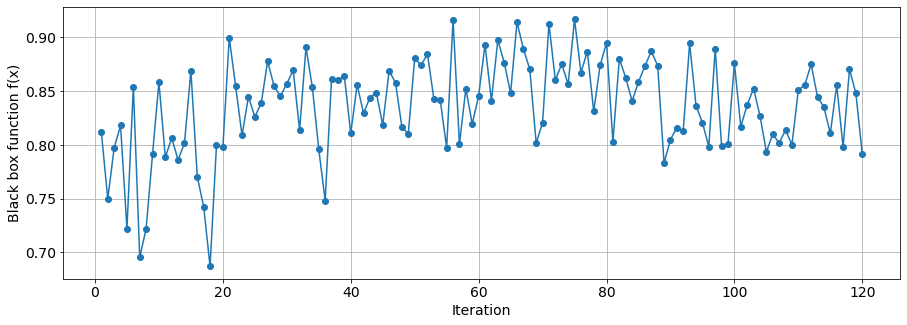

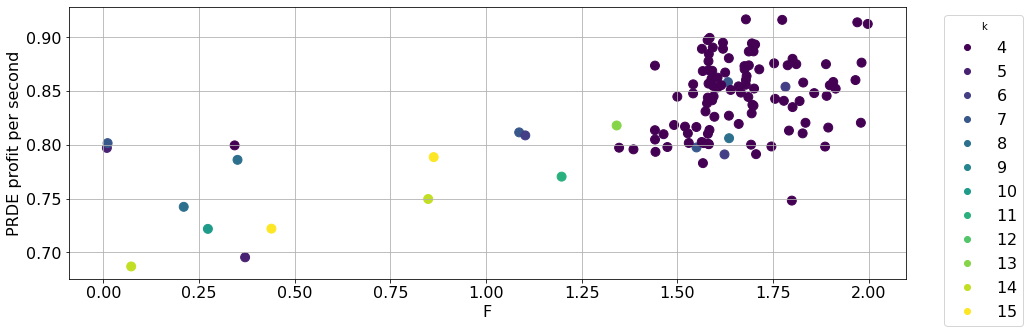

In [9]:
plot_target_val(optimiser)
plot_k_f(optimiser)

In [15]:
# pickle_obj(optimiser, 'mut_optimiser_best.txt')
# pickle_obj(bounds_transformer, 'bounds_transformer_best.txt')

Note: the target value (pps) does not seem to converge in any meaningful way throughout the optimisation process.

It appears that values of F closer to 2 and a k=4 has the best performance. Further analysis is required to determine whether this is statistically significant.

### Questions
- Do I need to show that the target value converges as the simulation comes to an end or is the graph above good enough evidence to attempt a statistical test on the traders?
- Should I be including simulation time in my report?
- 

## Further analysis
- Complete another Bayesian Optimisation simulation but look at the range from:
    - k = (4-7) and F = (1.5-2)
- See if the results converge in this case.

In [5]:
# define optimisation space
pbounds = {'k': (3.5, 7.49), 'f': (1.5, 2)}

# initialise bayesian optimiser
optimiser = BayesianOptimization(run_market_session, pbounds, 
                                 verbose=2, random_state=100)

In [6]:
epsilon = 0.15 # measure of exploitation-exploration
num_trials = 100
explore = int(num_trials * epsilon)
exploit = int(num_trials * (1 - epsilon))
print(f'Epsilon: {epsilon} \nExplore: {explore} \nExploit: {exploit}')

Epsilon: 0.15 
Explore: 15 
Exploit: 85


In [7]:
start = time.time()

# maximise profit of traders
optimiser.maximize(init_points = explore, n_iter = exploit)

print(f'Time taken (hours):', (time.time() - start)/60/60)

|   iter    |  target   |     f     |     k     |
-------------------------------------------------
| 1         | 0.8977    | 1.772     | 4.611     |
| 2         | 0.86      | 1.712     | 6.871     |
| 3         | 0.846     | 1.502     | 3.985     |
| 4         | 0.8477    | 1.835     | 6.795     |
| 5         | 0.8195    | 1.568     | 5.795     |
| 6         | 0.8601    | 1.946     | 4.335     |
| 7         | 0.863     | 1.593     | 3.932     |
| 8         | 0.8176    | 1.61      | 7.405     |
| 9         | 0.8923    | 1.906     | 4.186     |
| 10        | 0.8428    | 1.908     | 4.594     |
| 11        | 0.8305    | 1.716     | 7.251     |
| 12        | 0.8116    | 1.909     | 4.841     |
| 13        | 0.8668    | 1.588     | 4.988     |
| 14        | 0.8163    | 1.503     | 4.507     |
| 15        | 0.8474    | 1.898     | 3.561     |
| 16        | 0.8589    | 1.586     | 3.591     |
| 17        | 0.8074    | 1.811     | 6.253     |
| 18        | 0.8357    | 1.717     | 4.643     |


| 100       | 0.8371    | 1.999     | 3.524     |
Time taken (hours): 13.44982656776905


In [8]:
print("Best result: {}; f(x) = {}.".format(optimiser.max["params"], optimiser.max["target"]))

Best result: {'f': 1.9983868340782938, 'k': 3.524969677829571}; f(x) = 0.9299943415586419.


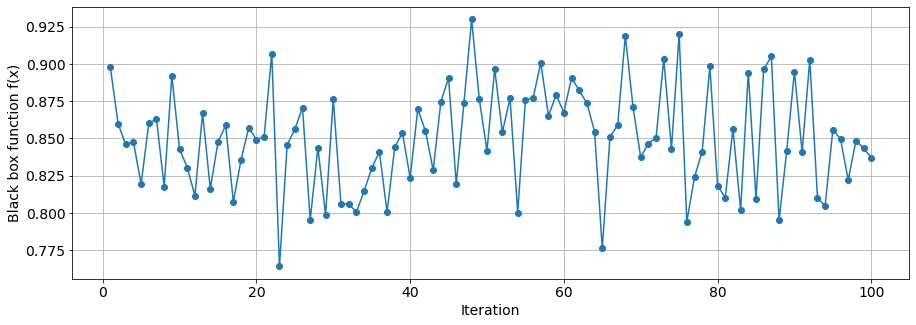

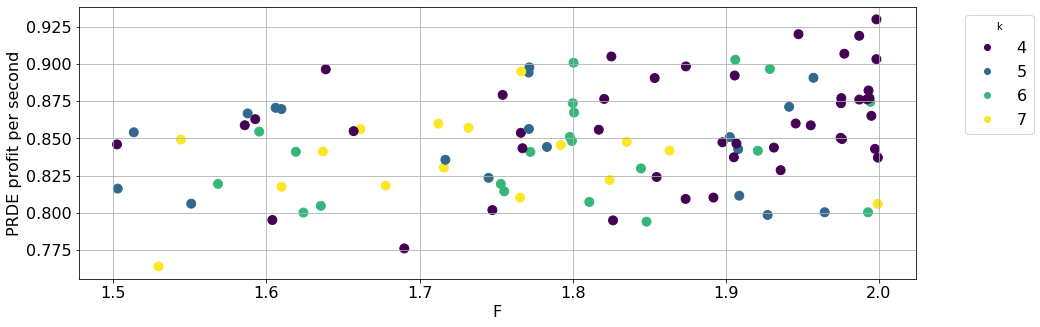

In [146]:
plot_target_val(optimiser)
plot_k_f(optimiser)

In [11]:
def pickle_obj(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
        
def unpickle_obj(filename):
    with open(filename, "rb") as pickle_off:
        obj = pickle.load(pickle_off)
        
    return obj

In [12]:
# test "unpickle" works correctly
o = unpickle_obj('optimiser.txt')
print(o.max)

{'target': 0.9299943415586419, 'params': {'f': 1.9983868340782938, 'k': 3.524969677829571}}


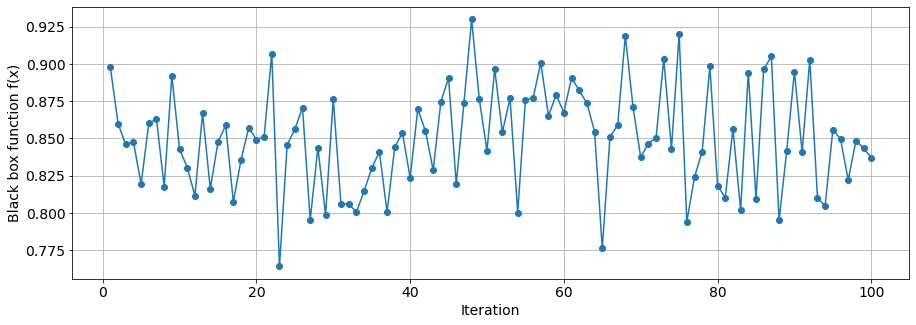

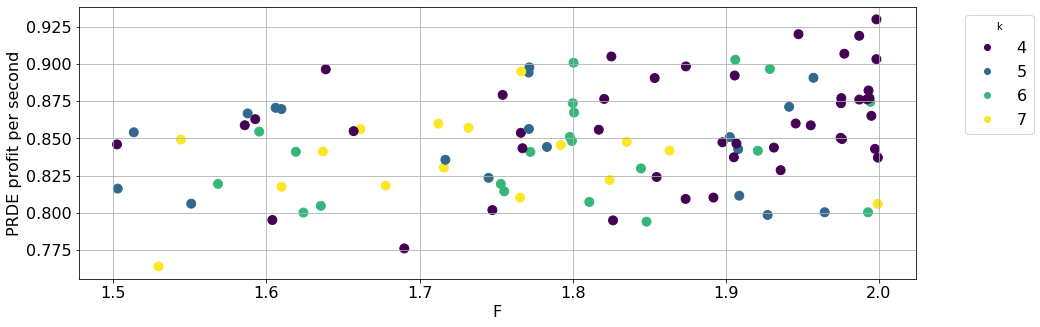

In [14]:
plot_target_val(o)
plot_k_f(o)

### Sequential Domain Reduction

Process where the bounds of the optimisation problem are mutated to reduce the time required to converge to an optimal value. Helps to provide convergence if the optimisation routine oscillates heavily.

- Process did not really produce the desired results

In [115]:
from bayes_opt import SequentialDomainReductionTransformer

In [135]:
bounds_transformer = SequentialDomainReductionTransformer(
    minimum_window=0.5
)

In [136]:
mutating_optimiser = BayesianOptimization(
    run_market_session, pbounds, verbose=2, random_state=100,
    bounds_transformer=bounds_transformer
)

In [137]:
start = time.time()
print("Start:", time.strftime("%H:%M", time.gmtime()), '\n')

# maximise profit of traders
mutating_optimiser.maximize(init_points = explore, n_iter = exploit)

print(f'Time taken (hours):', (time.time() - start)/60/60) 

Start: 21:02 

|   iter    |  target   |     f     |     k     |
-------------------------------------------------
| 1         | 0.8786    | 1.772     | 4.611     |
| 2         | 0.8463    | 1.712     | 6.871     |
| 3         | 0.8313    | 1.502     | 3.985     |
| 4         | 0.8422    | 1.835     | 6.795     |
| 5         | 0.7875    | 1.568     | 5.795     |
| 6         | 0.9071    | 1.946     | 4.335     |
| 7         | 0.7973    | 1.593     | 3.932     |
| 8         | 0.8708    | 1.61      | 7.405     |
| 9         | 0.9003    | 1.906     | 4.186     |
| 10        | 0.8746    | 1.908     | 4.594     |
| 11        | 0.8461    | 1.716     | 7.251     |
| 12        | 0.8787    | 1.909     | 4.841     |
| 13        | 0.8497    | 1.588     | 4.988     |
| 14        | 0.832     | 1.503     | 4.507     |
| 15        | 0.79      | 1.898     | 3.561     |
| 16        | 0.8178    | 1.784     | 4.33      |
| 17        | 0.783     | 2.017     | 4.247     |
| 18        | 0.8645    | 1.936    

| 100       | 0.8325    | 2.022     | 4.465     |
Time taken (hours): 12.709063274463016


In [143]:
pickle_obj(mutating_optimiser, 'mutating_optimiser.txt')
pickle_obj(bounds_transformer, 'bounds_transformer.txt')

In [139]:
print("Best result: {}; f(x) = {}.".format(mutating_optimiser.max["params"], mutating_optimiser.max["target"]))

Best result: {'f': 2.124478709896591, 'k': 4.41387478403719}; f(x) = 0.9171170267438272.


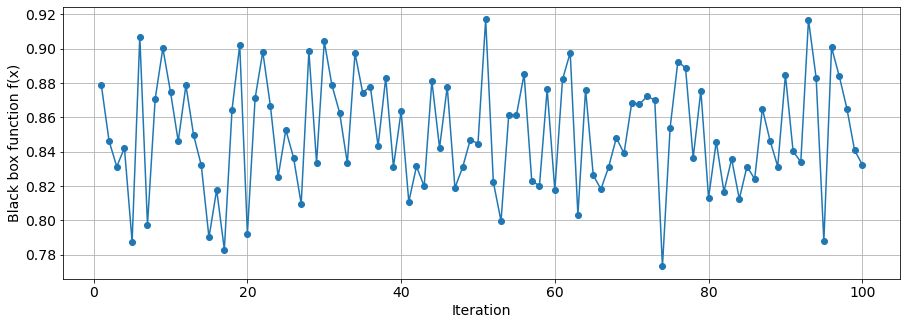

In [140]:
plot_target_val(mutating_optimiser)

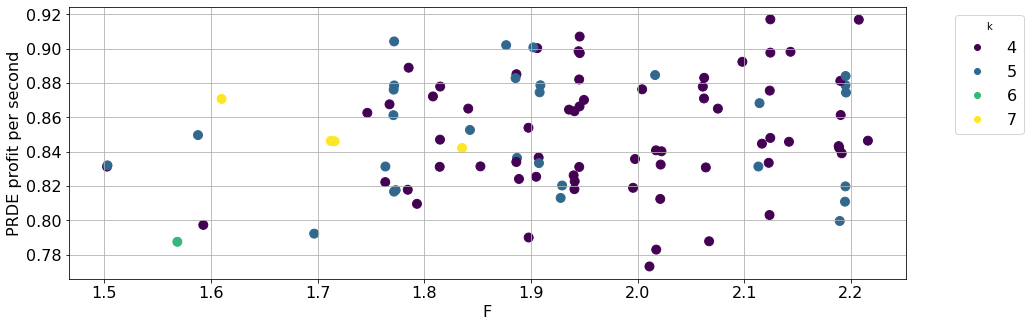

In [141]:
plot_k_f(mutating_optimiser, 0)

In [11]:
def plot_bounds(optimiser, transformer, param):
    min_bound = [b[0][0] for b in transformer.bounds]
    max_bound = [b[0][1] for b in transformer.bounds]
    
    x = [optimiser.res[i]['params'][param] for i, _ in enumerate(optimiser.res)]
    iteration = list(range(explore - 1, len(x)))
    
    plt.plot(iteration, min_bound, label=f'{param} lower bound')
    plt.plot(iteration, max_bound, label=f'{param} upper bound')
    plt.plot(x[explore-1:], label=param)
    plt.legend()

In [134]:
# plot_bounds(mutating_optimiser, bounds_transformer, 'f')

In [131]:
# example x-bound shrinking - we need to shift the x-axis by the init_points as the bounds
# transformer only mutates when searching - not in the initial phase.
f_min_bound = [b[0][0] for b in bounds_transformer.bounds]
f_max_bound = [b[0][1] for b in bounds_transformer.bounds]

k_min_bound = [b[1][0] for b in bounds_transformer.bounds]
k_max_bound = [b[1][1] for b in bounds_transformer.bounds]

k = [mutating_optimiser.res[i]['params']['k'] for i, _ in enumerate(mutating_optimiser.res)]
f = [mutating_optimiser.res[i]['params']['f'] for i, _ in enumerate(mutating_optimiser.res)]

bounds_transformers_iteration = list(range(explore - 1, len(f)))

In [132]:
plt.plot(bounds_transformers_iteration, f_min_bound, label='F lower bound')
plt.plot(bounds_transformers_iteration, f_max_bound, label='F upper bound')
plt.plot(f[explore-1:], label='F')
plt.legend()

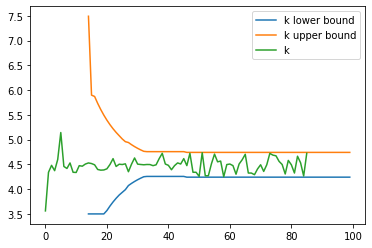

In [98]:
plt.plot(bounds_transformers_iteration, k_min_bound, label='k lower bound')
plt.plot(bounds_transformers_iteration, k_max_bound, label='k upper bound')
plt.plot(k[explore-1:], label='k')
plt.legend()